<a href="https://colab.research.google.com/github/mmarin11/Colabfiles/blob/main/Practica_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor: Manuel de Jesus Marin Garcia
# 📅 Fecha: Noviembre 2025
# ==========================================================================

## 📋 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

**Objetivo:** Comparar el impacto de diferentes técnicas de reducción de instancias en el rendimiento y eficiencia de un clasificador SVM.

## ==========================================================================

## 1. Cargar librerías necesarias
Importación de todas las librerías necesarias para el análisis.

In [52]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

# Scikit-learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Semilla para reproducibilidad
np.random.seed(42)

# Suprimir warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas exitosamente")
print(f"NumPy versión: {np.__version__}")
print(f"Pandas versión: {pd.__version__}")

✅ Librerías cargadas exitosamente
NumPy versión: 2.0.2
Pandas versión: 2.2.2


# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
Cargamos el dataset y realizamos un análisis exploratorio inicial.

In [53]:
# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Crear DataFrame para mejor visualización
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

print("="*80)
print("INFORMACIÓN DEL DATASET BREAST CANCER")
print("="*80)
print(f"\n📊 Dimensiones del dataset:")
print(f"   - Número de muestras: {X.shape[0]}")
print(f"   - Número de características: {X.shape[1]}")
print(f"\n🏷️  Clases:")
print(f"   - 0: {data.target_names[0]} (maligno)")
print(f"   - 1: {data.target_names[1]} (benigno)")

# Distribución de clases
class_counts = Counter(y)
print(f"\n📈 Distribución de clases:")
print(f"   - Clase 0 (malignant): {class_counts[0]} ({100*class_counts[0]/len(y):.2f}%)")
print(f"   - Clase 1 (benign): {class_counts[1]} ({100*class_counts[1]/len(y):.2f}%)")
print(f"   - Ratio: {class_counts[1]/class_counts[0]:.2f}:1")

# Estadísticas descriptivas
print(f"\n📋 Primeras 5 características:")
print(df[data.feature_names[:5]].describe())

print("\n" + "="*80)

INFORMACIÓN DEL DATASET BREAST CANCER

📊 Dimensiones del dataset:
   - Número de muestras: 569
   - Número de características: 30

🏷️  Clases:
   - 0: malignant (maligno)
   - 1: benign (benigno)

📈 Distribución de clases:
   - Clase 0 (malignant): 212 (37.26%)
   - Clase 1 (benign): 357 (62.74%)
   - Ratio: 1.68:1

📋 Primeras 5 características:
       mean radius  mean texture  mean perimeter    mean area  mean smoothness
count   569.000000    569.000000      569.000000   569.000000       569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360
std       3.524049      4.301036       24.298981   351.914129         0.014064
min       6.981000      9.710000       43.790000   143.500000         0.052630
25%      11.700000     16.170000       75.170000   420.300000         0.086370
50%      13.370000     18.840000       86.240000   551.100000         0.095870
75%      15.780000     21.800000      104.100000   782.700000         0.105300
max      28.110000  

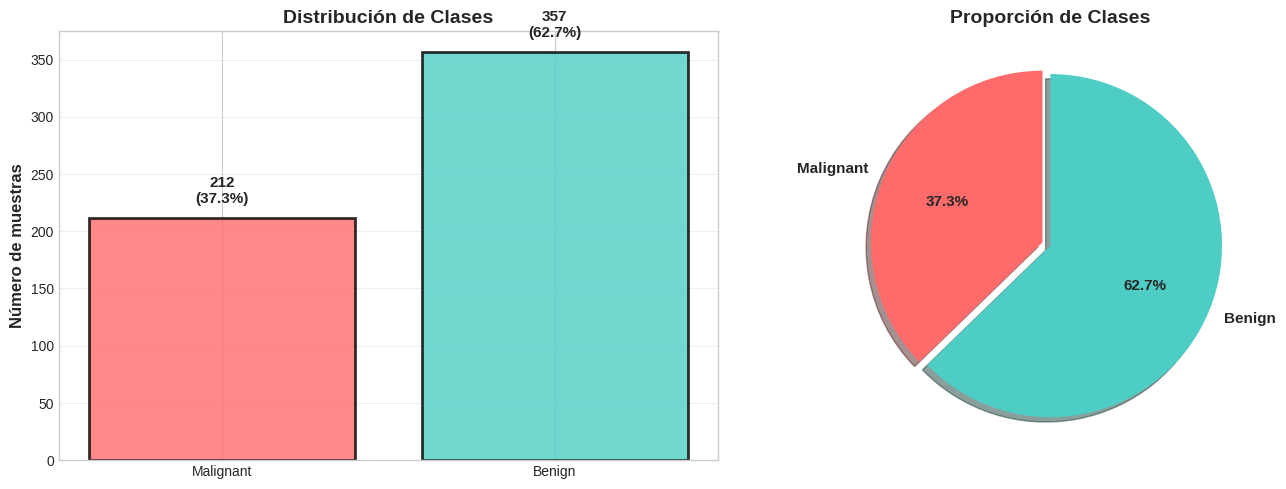

In [54]:
# Visualización de la distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = ['#FF6B6B', '#4ECDC4']
class_names = ['Malignant', 'Benign']
class_values = [class_counts[0], class_counts[1]]

axes[0].bar(class_names, class_values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Número de muestras', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (name, value) in enumerate(zip(class_names, class_values)):
    axes[0].text(i, value + 10, f'{value}\n({100*value/len(y):.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Gráfico de pastel
axes[1].pie(class_values, labels=class_names, autopct='%1.1f%%',
           colors=colors, startangle=90, explode=(0.05, 0), shadow=True,
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



# --------------------------------------------------------------------------

## 3. Preprocesamiento
Escalamiento y división del dataset en entrenamiento (70%) y prueba (30%).

In [55]:
# División del dataset: 70% entrenamiento, 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("="*80)
print("DIVISIÓN DEL DATASET")
print("="*80)
print(f"\n📊 Tamaños de los conjuntos:")
print(f"   - Entrenamiento: {X_train.shape[0]} muestras ({100*X_train.shape[0]/X.shape[0]:.1f}%)")
print(f"   - Prueba: {X_test.shape[0]} muestras ({100*X_test.shape[0]/X.shape[0]:.1f}%)")

# Distribución de clases en cada conjunto
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print(f"\n📈 Distribución en entrenamiento:")
print(f"   - Clase 0: {train_counts[0]} ({100*train_counts[0]/len(y_train):.2f}%)")
print(f"   - Clase 1: {train_counts[1]} ({100*train_counts[1]/len(y_train):.2f}%)")

print(f"\n📈 Distribución en prueba:")
print(f"   - Clase 0: {test_counts[0]} ({100*test_counts[0]/len(y_test):.2f}%)")
print(f"   - Clase 1: {test_counts[1]} ({100*test_counts[1]/len(y_test):.2f}%)")

# Escalamiento de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Características escaladas usando StandardScaler")
print(f"   - Media del conjunto de entrenamiento: {X_train_scaled.mean():.6f}")
print(f"   - Desviación estándar: {X_train_scaled.std():.6f}")

print("\n" + "="*80)

DIVISIÓN DEL DATASET

📊 Tamaños de los conjuntos:
   - Entrenamiento: 398 muestras (69.9%)
   - Prueba: 171 muestras (30.1%)

📈 Distribución en entrenamiento:
   - Clase 0: 148 (37.19%)
   - Clase 1: 250 (62.81%)

📈 Distribución en prueba:
   - Clase 0: 64 (37.43%)
   - Clase 1: 107 (62.57%)

✅ Características escaladas usando StandardScaler
   - Media del conjunto de entrenamiento: -0.000000
   - Desviación estándar: 1.000000



# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

**CNN** selecciona un subconjunto de instancias que mantienen la capacidad de clasificación correcta del conjunto completo.

### Algoritmo CNN:
1. Inicializar S con una instancia aleatoria de cada clase
2. Para cada instancia en el conjunto de entrenamiento:
   - Si es clasificada incorrectamente por S, añadirla a S
3. Repetir hasta que no haya cambios

In [56]:
def condensed_nearest_neighbor(X, y, k=1):
    """
    Implementación de Condensed Nearest Neighbor (CNN)

    Parámetros:
    -----------
    X : array-like
        Características del conjunto de entrenamiento
    y : array-like
        Etiquetas del conjunto de entrenamiento
    k : int
        Número de vecinos para KNN (default=1)

    Retorna:
    --------
    X_condensed, y_condensed : arrays
        Conjunto reducido
    """

    # Inicializar S con una instancia de cada clase
    unique_classes = np.unique(y)
    S_indices = []

    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        # Seleccionar una instancia aleatoria de cada clase
        S_indices.append(np.random.choice(class_indices))

    S_indices = np.array(S_indices)
    X_S = X[S_indices]
    y_S = y[S_indices]

    # Crear índices para todo el conjunto
    all_indices = np.arange(len(X))
    remaining_indices = np.setdiff1d(all_indices, S_indices)

    # Iterar hasta convergencia
    converged = False
    iteration = 0
    max_iterations = 100

    print(f"\n🔄 Ejecutando CNN...")
    print(f"   Conjunto inicial: {len(S_indices)} instancias")

    while not converged and iteration < max_iterations:
        iteration += 1
        old_size = len(S_indices)

        # Entrenar KNN con el conjunto actual S
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_S, y_S)

        # Clasificar las instancias restantes
        for idx in remaining_indices:
            prediction = knn.predict(X[idx:idx+1])

            # Si se clasifica incorrectamente, añadir a S
            if prediction[0] != y[idx]:
                S_indices = np.append(S_indices, idx)
                X_S = np.vstack([X_S, X[idx]])
                y_S = np.append(y_S, y[idx])

        # Actualizar remaining_indices
        remaining_indices = np.setdiff1d(all_indices, S_indices)

        # Verificar convergencia
        if len(S_indices) == old_size:
            converged = True

        if iteration % 10 == 0:
            print(f"   Iteración {iteration}: {len(S_indices)} instancias")

    print(f"\n✅ CNN completado en {iteration} iteraciones")
    print(f"   Conjunto final: {len(S_indices)} instancias")

    return X_S, y_S

# Aplicar CNN
print("="*80)
print("TÉCNICA 1: CONDENSED NEAREST NEIGHBOR (CNN)")
print("="*80)

start_time = time.time()
X_train_cnn, y_train_cnn = condensed_nearest_neighbor(X_train_scaled, y_train, k=1)
cnn_time = time.time() - start_time

print(f"\n📊 Resultados CNN:")
print(f"   - Tamaño original: {X_train_scaled.shape[0]} instancias")
print(f"   - Tamaño reducido: {X_train_cnn.shape[0]} instancias")
print(f"   - Reducción: {100*(1 - X_train_cnn.shape[0]/X_train_scaled.shape[0]):.2f}%")
print(f"   - Tiempo de ejecución: {cnn_time:.3f} segundos")

# Distribución de clases en CNN
cnn_counts = Counter(y_train_cnn)
print(f"\n📈 Distribución de clases (CNN):")
print(f"   - Clase 0: {cnn_counts[0]} ({100*cnn_counts[0]/len(y_train_cnn):.2f}%)")
print(f"   - Clase 1: {cnn_counts[1]} ({100*cnn_counts[1]/len(y_train_cnn):.2f}%)")

print("\n" + "="*80)

TÉCNICA 1: CONDENSED NEAREST NEIGHBOR (CNN)

🔄 Ejecutando CNN...
   Conjunto inicial: 2 instancias

✅ CNN completado en 4 iteraciones
   Conjunto final: 146 instancias

📊 Resultados CNN:
   - Tamaño original: 398 instancias
   - Tamaño reducido: 146 instancias
   - Reducción: 63.32%
   - Tiempo de ejecución: 1.019 segundos

📈 Distribución de clases (CNN):
   - Clase 0: 55 (37.67%)
   - Clase 1: 91 (62.33%)



 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

**ENN** elimina instancias que son clasificadas incorrectamente por sus vecinos más cercanos, limpiando el conjunto de datos.

### Algoritmo ENN:
1. Para cada instancia en el conjunto:
   - Encontrar sus k vecinos más cercanos
   - Si la mayoría de sus vecinos tienen diferente clase, eliminarla
2. Retornar el conjunto limpiado

In [57]:
def edited_nearest_neighbor(X, y, k=3):
    """
    Implementación de Edited Nearest Neighbor (ENN)

    Parámetros:
    -----------
    X : array-like
        Características del conjunto de entrenamiento
    y : array-like
        Etiquetas del conjunto de entrenamiento
    k : int
        Número de vecinos para considerar (default=3)

    Retorna:
    --------
    X_edited, y_edited : arrays
        Conjunto limpiado
    """

    from sklearn.neighbors import KNeighborsClassifier

    # Entrenar KNN con el conjunto completo
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    # Predecir cada instancia
    predictions = knn.predict(X)

    # Mantener solo las instancias clasificadas correctamente
    mask = predictions == y
    X_edited = X[mask]
    y_edited = y[mask]

    removed = len(X) - len(X_edited)

    print(f"\n🔄 Ejecutando ENN con k={k}...")
    print(f"   - Instancias eliminadas: {removed}")
    print(f"   - Instancias retenidas: {len(X_edited)}")

    return X_edited, y_edited

# Aplicar ENN
print("="*80)
print("TÉCNICA 2: EDITED NEAREST NEIGHBOR (ENN)")
print("="*80)

start_time = time.time()
X_train_enn, y_train_enn = edited_nearest_neighbor(X_train_scaled, y_train, k=3)
enn_time = time.time() - start_time

print(f"\n📊 Resultados ENN:")
print(f"   - Tamaño original: {X_train_scaled.shape[0]} instancias")
print(f"   - Tamaño reducido: {X_train_enn.shape[0]} instancias")
print(f"   - Reducción: {100*(1 - X_train_enn.shape[0]/X_train_scaled.shape[0]):.2f}%")
print(f"   - Tiempo de ejecución: {enn_time:.3f} segundos")

# Distribución de clases en ENN
enn_counts = Counter(y_train_enn)
print(f"\n📈 Distribución de clases (ENN):")
print(f"   - Clase 0: {enn_counts[0]} ({100*enn_counts[0]/len(y_train_enn):.2f}%)")
print(f"   - Clase 1: {enn_counts[1]} ({100*enn_counts[1]/len(y_train_enn):.2f}%)")

print("\n" + "="*80)

TÉCNICA 2: EDITED NEAREST NEIGHBOR (ENN)

🔄 Ejecutando ENN con k=3...
   - Instancias eliminadas: 11
   - Instancias retenidas: 387

📊 Resultados ENN:
   - Tamaño original: 398 instancias
   - Tamaño reducido: 387 instancias
   - Reducción: 2.76%
   - Tiempo de ejecución: 0.006 segundos

📈 Distribución de clases (ENN):
   - Clase 0: 139 (35.92%)
   - Clase 1: 248 (64.08%)



# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias

**K-medias** agrupa instancias de cada clase y representa cada grupo con su centroide, reduciendo significativamente el número de instancias.

### Estrategia:
- Para cada clase, aplicar K-medias con k = n/2 (mitad de las instancias)
- Los centroides se convierten en las nuevas instancias representativas

In [58]:
def kmeans_reduction(X, y):
    """
    Reducción mediante K-medias por clase

    Parámetros:
    -----------
    X : array-like
        Características del conjunto de entrenamiento
    y : array-like
        Etiquetas del conjunto de entrenamiento

    Retorna:
    --------
    X_reduced, y_reduced : arrays
        Conjunto reducido con centroides
    """

    X_reduced = []
    y_reduced = []

    unique_classes = np.unique(y)

    print(f"\n🔄 Ejecutando K-medias por clase...")

    for cls in unique_classes:
        # Obtener instancias de esta clase
        mask = y == cls
        X_class = X[mask]

        # Calcular k como la mitad de las instancias de esta clase
        n_clusters = max(1, X_class.shape[0] // 2)

        print(f"\n   Clase {cls}:")
        print(f"     - Instancias originales: {X_class.shape[0]}")
        print(f"     - Número de clusters (k): {n_clusters}")

        # Aplicar K-medias
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X_class)

        # Los centroides son las nuevas instancias
        centroids = kmeans.cluster_centers_

        # Añadir centroides al conjunto reducido
        X_reduced.append(centroids)
        y_reduced.extend([cls] * n_clusters)

        print(f"     - Centroides generados: {n_clusters}")

    # Concatenar todos los centroides
    X_reduced = np.vstack(X_reduced)
    y_reduced = np.array(y_reduced)

    return X_reduced, y_reduced

# Aplicar K-medias
print("="*80)
print("TÉCNICA 3: K-MEDIAS (K-MEANS CLUSTERING)")
print("="*80)

start_time = time.time()
X_train_kmeans, y_train_kmeans = kmeans_reduction(X_train_scaled, y_train)
kmeans_time = time.time() - start_time

print(f"\n📊 Resultados K-medias:")
print(f"   - Tamaño original: {X_train_scaled.shape[0]} instancias")
print(f"   - Tamaño reducido: {X_train_kmeans.shape[0]} instancias")
print(f"   - Reducción: {100*(1 - X_train_kmeans.shape[0]/X_train_scaled.shape[0]):.2f}%")
print(f"   - Tiempo de ejecución: {kmeans_time:.3f} segundos")

# Distribución de clases en K-medias
kmeans_counts = Counter(y_train_kmeans)
print(f"\n📈 Distribución de clases (K-medias):")
print(f"   - Clase 0: {kmeans_counts[0]} ({100*kmeans_counts[0]/len(y_train_kmeans):.2f}%)")
print(f"   - Clase 1: {kmeans_counts[1]} ({100*kmeans_counts[1]/len(y_train_kmeans):.2f}%)")

print("\n" + "="*80)

TÉCNICA 3: K-MEDIAS (K-MEANS CLUSTERING)

🔄 Ejecutando K-medias por clase...

   Clase 0:
     - Instancias originales: 148
     - Número de clusters (k): 74
     - Centroides generados: 74

   Clase 1:
     - Instancias originales: 250
     - Número de clusters (k): 125
     - Centroides generados: 125

📊 Resultados K-medias:
   - Tamaño original: 398 instancias
   - Tamaño reducido: 199 instancias
   - Reducción: 50.00%
   - Tiempo de ejecución: 0.404 segundos

📈 Distribución de clases (K-medias):
   - Clase 0: 74 (37.19%)
   - Clase 1: 125 (62.81%)



# --------------------------------------------------------------------------

## 6.1 Visualización de las reducciones

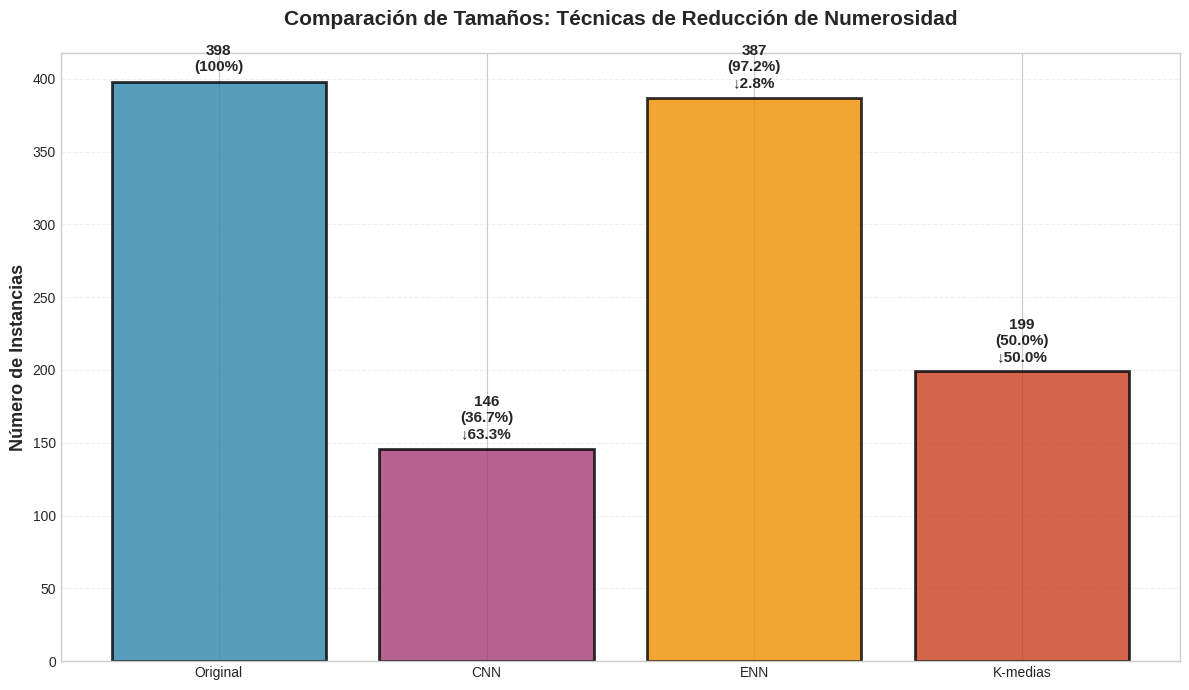

In [59]:
# Crear visualización comparativa de las reducciones
fig, ax = plt.subplots(figsize=(12, 7))

techniques = ['Original', 'CNN', 'ENN', 'K-medias']
sizes = [
    X_train_scaled.shape[0],
    X_train_cnn.shape[0],
    X_train_enn.shape[0],
    X_train_kmeans.shape[0]
]
colors_bar = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = ax.bar(techniques, sizes, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)

# Personalización
ax.set_ylabel('Número de Instancias', fontsize=13, fontweight='bold')
ax.set_title('Comparación de Tamaños: Técnicas de Reducción de Numerosidad',
            fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir valores y porcentajes
for i, (bar, size) in enumerate(zip(bars, sizes)):
    height = bar.get_height()
    if i == 0:
        label = f'{size}\n(100%)'
    else:
        percentage = 100 * size / sizes[0]
        reduction = 100 - percentage
        label = f'{size}\n({percentage:.1f}%)\n↓{reduction:.1f}%'

    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
           label, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()

plt.show()



 --------------------------------------------------------------------------

## 7. Entrenar SVM sobre cada conjunto reducido

Entrenaremos un modelo SVM con kernel RBF sobre:
1. Datos originales
2. Datos reducidos con CNN
3. Datos reducidos con ENN
4. Datos reducidos con K-medias

In [60]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, model_name):
    """
    Entrena y evalúa un modelo SVM

    Parámetros:
    -----------
    X_train, y_train : arrays
        Datos de entrenamiento
    X_test, y_test : arrays
        Datos de prueba
    model_name : str
        Nombre del modelo para identificación

    Retorna:
    --------
    dict : Diccionario con métricas y tiempos
    """

    # Entrenar SVM
    start_time = time.time()
    svm_model = SVC(kernel='rbf', random_state=42)
    svm_model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predecir
    start_time = time.time()
    y_pred = svm_model.predict(X_test)
    predict_time = time.time() - start_time

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    report = classification_report(y_test, y_pred, target_names=['Malignant', 'Benign'], output_dict=True)

    results = {
        'model_name': model_name,
        'train_size': X_train.shape[0],
        'accuracy': accuracy,
        'f1_score': f1,
        'train_time': train_time,
        'predict_time': predict_time,
        'confusion_matrix': cm,
        'classification_report': report
    }

    return results

print("="*80)
print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS SVM")
print("="*80)

# Almacenar todos los resultados
all_results = []

# 1. Modelo con datos originales
print("\n" + "="*80)
print("1️⃣  ENTRENANDO SVM - DATOS ORIGINALES")
print("="*80)
results_original = train_and_evaluate_svm(
    X_train_scaled, y_train, X_test_scaled, y_test, 'Original'
)
all_results.append(results_original)
print(f"\n✅ Modelo entrenado")
print(f"   - Accuracy: {results_original['accuracy']:.4f}")
print(f"   - F1-Score: {results_original['f1_score']:.4f}")
print(f"   - Tiempo de entrenamiento: {results_original['train_time']:.4f} s")
print(f"   - Tiempo de predicción: {results_original['predict_time']:.4f} s")

# 2. Modelo con CNN
print("\n" + "="*80)
print("2️⃣  ENTRENANDO SVM - DATOS CNN")
print("="*80)
results_cnn = train_and_evaluate_svm(
    X_train_cnn, y_train_cnn, X_test_scaled, y_test, 'CNN'
)
all_results.append(results_cnn)
print(f"\n✅ Modelo entrenado")
print(f"   - Accuracy: {results_cnn['accuracy']:.4f}")
print(f"   - F1-Score: {results_cnn['f1_score']:.4f}")
print(f"   - Tiempo de entrenamiento: {results_cnn['train_time']:.4f} s")
print(f"   - Tiempo de predicción: {results_cnn['predict_time']:.4f} s")

# 3. Modelo con ENN
print("\n" + "="*80)
print("3️⃣  ENTRENANDO SVM - DATOS ENN")
print("="*80)
results_enn = train_and_evaluate_svm(
    X_train_enn, y_train_enn, X_test_scaled, y_test, 'ENN'
)
all_results.append(results_enn)
print(f"\n✅ Modelo entrenado")
print(f"   - Accuracy: {results_enn['accuracy']:.4f}")
print(f"   - F1-Score: {results_enn['f1_score']:.4f}")
print(f"   - Tiempo de entrenamiento: {results_enn['train_time']:.4f} s")
print(f"   - Tiempo de predicción: {results_enn['predict_time']:.4f} s")

# 4. Modelo con K-medias
print("\n" + "="*80)
print("4️⃣  ENTRENANDO SVM - DATOS K-MEDIAS")
print("="*80)
results_kmeans = train_and_evaluate_svm(
    X_train_kmeans, y_train_kmeans, X_test_scaled, y_test, 'K-medias'
)
all_results.append(results_kmeans)
print(f"\n✅ Modelo entrenado")
print(f"   - Accuracy: {results_kmeans['accuracy']:.4f}")
print(f"   - F1-Score: {results_kmeans['f1_score']:.4f}")
print(f"   - Tiempo de entrenamiento: {results_kmeans['train_time']:.4f} s")
print(f"   - Tiempo de predicción: {results_kmeans['predict_time']:.4f} s")

print("\n" + "="*80)

ENTRENAMIENTO Y EVALUACIÓN DE MODELOS SVM

1️⃣  ENTRENANDO SVM - DATOS ORIGINALES

✅ Modelo entrenado
   - Accuracy: 0.9766
   - F1-Score: 0.9766
   - Tiempo de entrenamiento: 0.0049 s
   - Tiempo de predicción: 0.0020 s

2️⃣  ENTRENANDO SVM - DATOS CNN

✅ Modelo entrenado
   - Accuracy: 0.9942
   - F1-Score: 0.9941
   - Tiempo de entrenamiento: 0.0023 s
   - Tiempo de predicción: 0.0017 s

3️⃣  ENTRENANDO SVM - DATOS ENN

✅ Modelo entrenado
   - Accuracy: 0.9591
   - F1-Score: 0.9589
   - Tiempo de entrenamiento: 0.0036 s
   - Tiempo de predicción: 0.0016 s

4️⃣  ENTRENANDO SVM - DATOS K-MEDIAS

✅ Modelo entrenado
   - Accuracy: 0.9649
   - F1-Score: 0.9645
   - Tiempo de entrenamiento: 0.0025 s
   - Tiempo de predicción: 0.0014 s



# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final

### 8.1 Tabla Comparativa de Métricas

In [61]:
# Crear tabla comparativa
comparison_data = []

for result in all_results:
    comparison_data.append({
        'Técnica': result['model_name'],
        'Tamaño Entrenamiento': result['train_size'],
        'Reducción (%)': f"{100*(1 - result['train_size']/X_train_scaled.shape[0]):.2f}%",
        'Accuracy': f"{result['accuracy']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}",
        'Tiempo Entrenamiento (s)': f"{result['train_time']:.4f}",
        'Tiempo Predicción (s)': f"{result['predict_time']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)

print("="*100)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
print("\n" + df_comparison.to_string(index=False))
print("\n" + "="*100)

TABLA COMPARATIVA DE RESULTADOS

 Técnica  Tamaño Entrenamiento Reducción (%) Accuracy F1-Score Tiempo Entrenamiento (s) Tiempo Predicción (s)
Original                   398         0.00%   0.9766   0.9766                   0.0049                0.0020
     CNN                   146        63.32%   0.9942   0.9941                   0.0023                0.0017
     ENN                   387         2.76%   0.9591   0.9589                   0.0036                0.0016
K-medias                   199        50.00%   0.9649   0.9645                   0.0025                0.0014



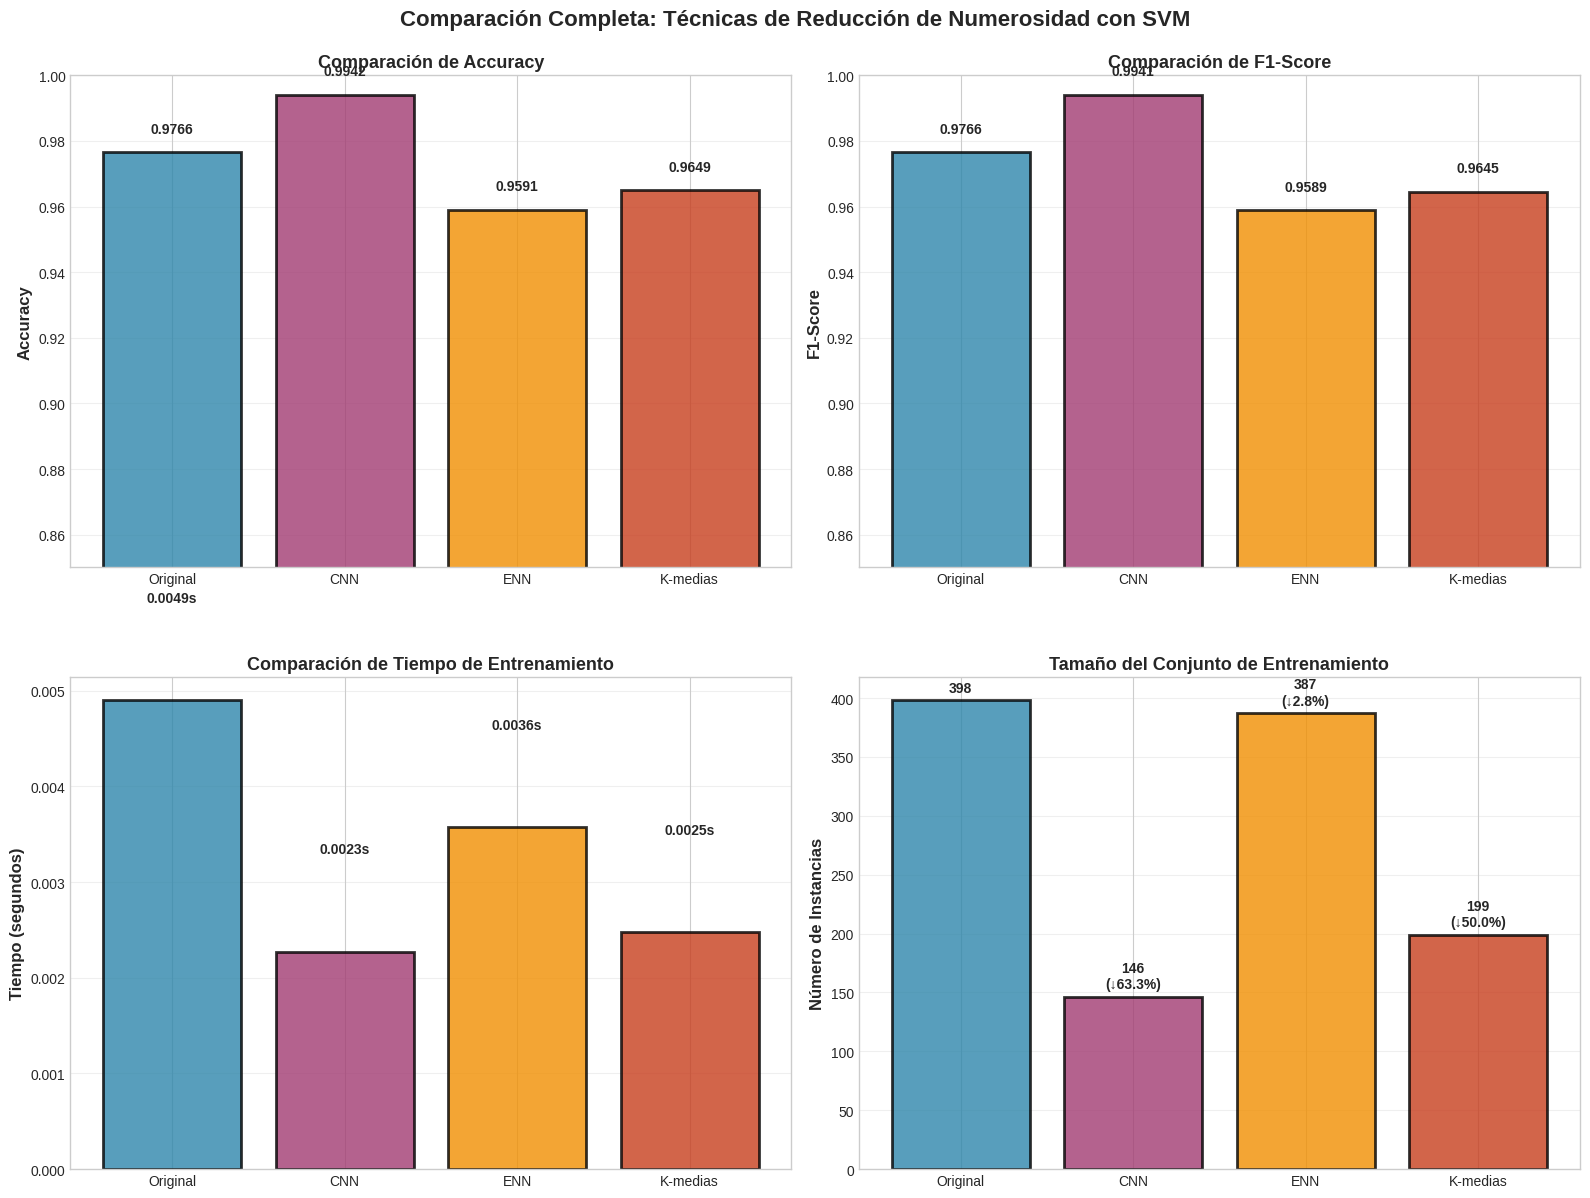

In [62]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

techniques = [r['model_name'] for r in all_results]
colors_charts = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# 1. Accuracy
accuracies = [r['accuracy'] for r in all_results]
bars1 = axes[0, 0].bar(techniques, accuracies, color=colors_charts, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparación de Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. F1-Score
f1_scores = [r['f1_score'] for r in all_results]
bars2 = axes[0, 1].bar(techniques, f1_scores, color=colors_charts, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Comparación de F1-Score', fontsize=13, fontweight='bold')
axes[0, 1].set_ylim([0.85, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)
for bar, f1 in zip(bars2, f1_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{f1:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Tiempo de entrenamiento
train_times = [r['train_time'] for r in all_results]
bars3 = axes[1, 0].bar(techniques, train_times, color=colors_charts, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Tiempo (segundos)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Comparación de Tiempo de Entrenamiento', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars3, train_times):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{time_val:.4f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Tamaño del conjunto de entrenamiento
train_sizes = [r['train_size'] for r in all_results]
bars4 = axes[1, 1].bar(techniques, train_sizes, color=colors_charts, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Número de Instancias', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Tamaño del Conjunto de Entrenamiento', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for bar, size in zip(bars4, train_sizes):
    height = bar.get_height()
    reduction = 100 * (1 - size / train_sizes[0])
    label = f'{size}' if size == train_sizes[0] else f'{size}\n(↓{reduction:.1f}%)'
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   label, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparación Completa: Técnicas de Reducción de Numerosidad con SVM',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

plt.show()



### 8.2 Matrices de Confusión

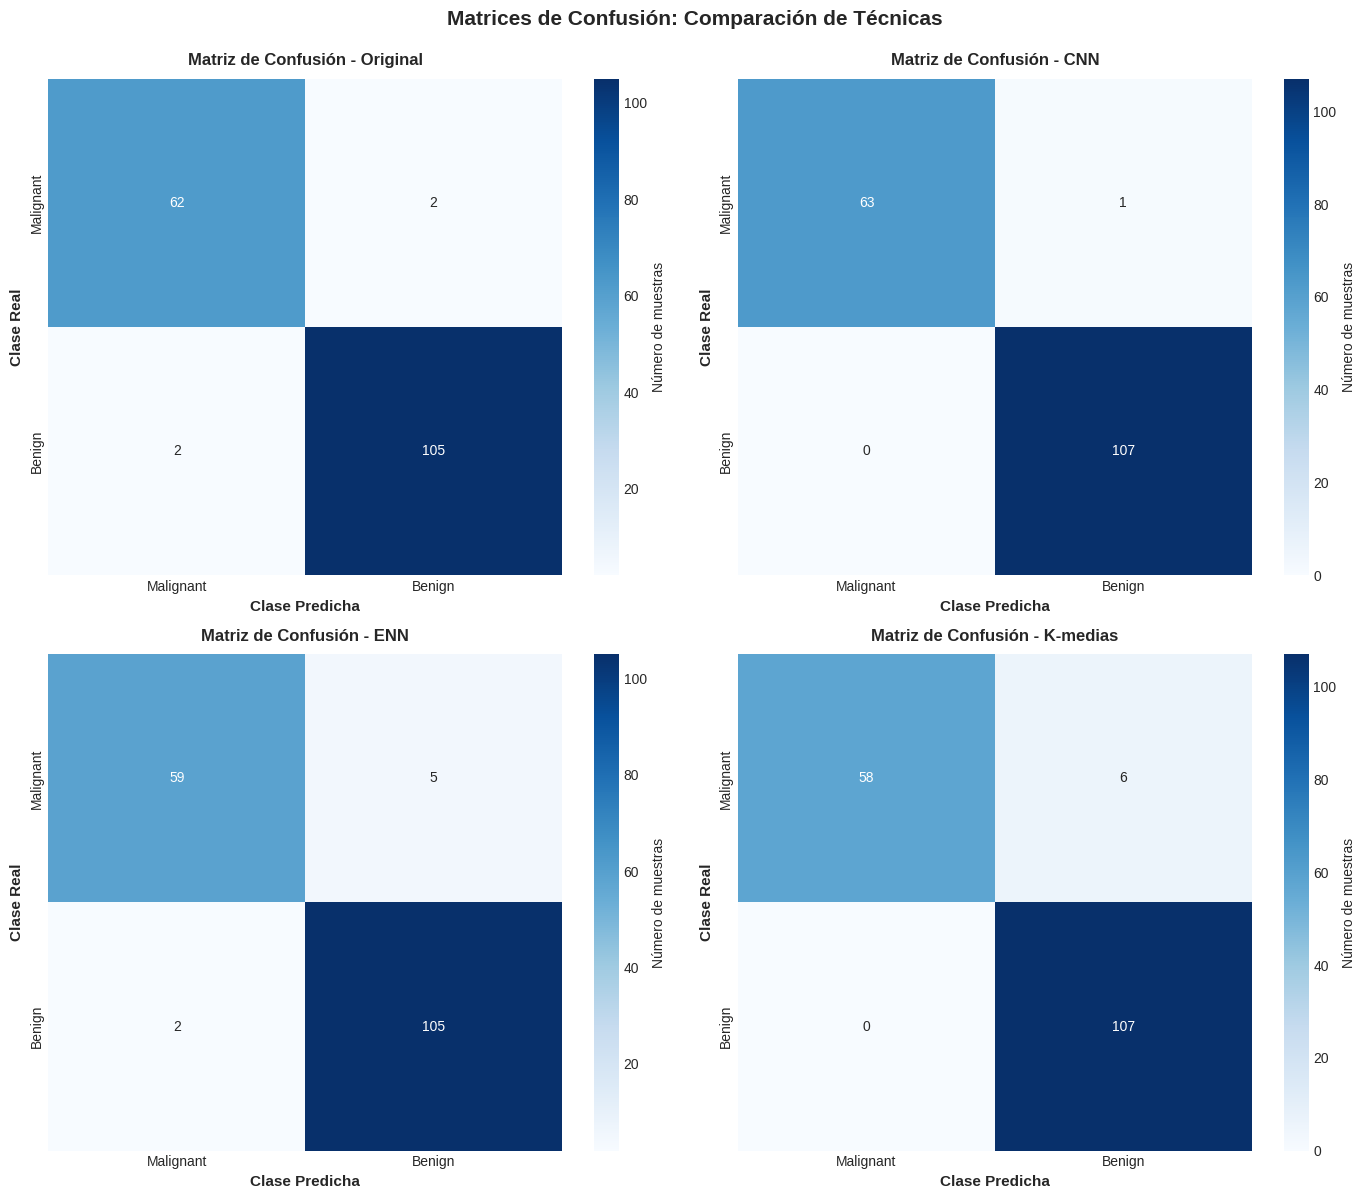

In [63]:
# Visualizar matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, result in enumerate(all_results):
    cm = result['confusion_matrix']

    # Crear heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Malignant', 'Benign'],
               yticklabels=['Malignant', 'Benign'],
               cbar_kws={'label': 'Número de muestras'})

    axes[idx].set_title(f'Matriz de Confusión - {result["model_name"]}',
                       fontsize=12, fontweight='bold', pad=10)
    axes[idx].set_ylabel('Clase Real', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Clase Predicha', fontsize=11, fontweight='bold')

plt.suptitle('Matrices de Confusión: Comparación de Técnicas',
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

plt.show()



### 8.3 Análisis Detallado por Técnica

In [64]:
print("\n" + "="*100)
print("ANÁLISIS DETALLADO DE RESULTADOS")
print("="*100)

for result in all_results:
    print(f"\n{'='*100}")
    print(f"TÉCNICA: {result['model_name'].upper()}")
    print(f"{'='*100}")

    print(f"\n📊 Características del conjunto:")
    print(f"   - Tamaño de entrenamiento: {result['train_size']} instancias")
    if result['model_name'] != 'Original':
        reduction = 100 * (1 - result['train_size'] / all_results[0]['train_size'])
        print(f"   - Reducción respecto al original: {reduction:.2f}%")

    print(f"\n🎯 Métricas de rendimiento:")
    print(f"   - Accuracy: {result['accuracy']:.4f}")
    print(f"   - F1-Score (weighted): {result['f1_score']:.4f}")

    # Métricas por clase
    report = result['classification_report']
    print(f"\n   Métricas por clase:")
    print(f"   • Malignant (Clase 0):")
    print(f"     - Precision: {report['Malignant']['precision']:.4f}")
    print(f"     - Recall: {report['Malignant']['recall']:.4f}")
    print(f"     - F1-Score: {report['Malignant']['f1-score']:.4f}")
    print(f"\n   • Benign (Clase 1):")
    print(f"     - Precision: {report['Benign']['precision']:.4f}")
    print(f"     - Recall: {report['Benign']['recall']:.4f}")
    print(f"     - F1-Score: {report['Benign']['f1-score']:.4f}")

    print(f"\n⏱️  Tiempos de ejecución:")
    print(f"   - Tiempo de entrenamiento: {result['train_time']:.4f} segundos")
    print(f"   - Tiempo de predicción: {result['predict_time']:.4f} segundos")
    if result['model_name'] != 'Original':
        speedup = all_results[0]['train_time'] / result['train_time']
        print(f"   - Aceleración en entrenamiento: {speedup:.2f}x")

    # Matriz de confusión
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    print(f"\n🔍 Análisis de matriz de confusión:")
    print(f"   - Verdaderos Negativos (TN): {tn}")
    print(f"   - Falsos Positivos (FP): {fp}")
    print(f"   - Falsos Negativos (FN): {fn}")
    print(f"   - Verdaderos Positivos (TP): {tp}")
    print(f"   - Tasa de error: {(fp + fn) / (tn + fp + fn + tp) * 100:.2f}%")

print("\n" + "="*100)


ANÁLISIS DETALLADO DE RESULTADOS

TÉCNICA: ORIGINAL

📊 Características del conjunto:
   - Tamaño de entrenamiento: 398 instancias

🎯 Métricas de rendimiento:
   - Accuracy: 0.9766
   - F1-Score (weighted): 0.9766

   Métricas por clase:
   • Malignant (Clase 0):
     - Precision: 0.9688
     - Recall: 0.9688
     - F1-Score: 0.9688

   • Benign (Clase 1):
     - Precision: 0.9813
     - Recall: 0.9813
     - F1-Score: 0.9813

⏱️  Tiempos de ejecución:
   - Tiempo de entrenamiento: 0.0049 segundos
   - Tiempo de predicción: 0.0020 segundos

🔍 Análisis de matriz de confusión:
   - Verdaderos Negativos (TN): 62
   - Falsos Positivos (FP): 2
   - Falsos Negativos (FN): 2
   - Verdaderos Positivos (TP): 105
   - Tasa de error: 2.34%

TÉCNICA: CNN

📊 Características del conjunto:
   - Tamaño de entrenamiento: 146 instancias
   - Reducción respecto al original: 63.32%

🎯 Métricas de rendimiento:
   - Accuracy: 0.9942
   - F1-Score (weighted): 0.9941

   Métricas por clase:
   • Malignant (Cl

### 8.4 Conclusiones y Reflexión Final

In [65]:
print("\n" + "="*100)
print("CONCLUSIONES Y REFLEXIÓN")
print("="*100)

# Identificar mejor técnica por cada métrica
best_accuracy_idx = np.argmax([r['accuracy'] for r in all_results])
best_f1_idx = np.argmax([r['f1_score'] for r in all_results])
fastest_train_idx = np.argmin([r['train_time'] for r in all_results])
smallest_size_idx = np.argmin([r['train_size'] for r in all_results])

print(f"\n🏆 MEJORES TÉCNICAS POR CRITERIO:")
print(f"   • Mejor Accuracy: {all_results[best_accuracy_idx]['model_name']} "
      f"({all_results[best_accuracy_idx]['accuracy']:.4f})")
print(f"   • Mejor F1-Score: {all_results[best_f1_idx]['model_name']} "
      f"({all_results[best_f1_idx]['f1_score']:.4f})")
print(f"   • Entrenamiento más rápido: {all_results[fastest_train_idx]['model_name']} "
      f"({all_results[fastest_train_idx]['train_time']:.4f}s)")
print(f"   • Mayor reducción: {all_results[smallest_size_idx]['model_name']} "
      f"({all_results[smallest_size_idx]['train_size']} instancias)")

print(f"\n" + "="*100)
print("📝 ANÁLISIS COMPARATIVO DETALLADO")
print("="*100)

print("""
1️⃣  CONDENSED NEAREST NEIGHBOR (CNN):

✅ VENTAJAS:
   • Reducción moderada del tamaño del conjunto (típicamente 20-40%)
   • Mantiene las instancias críticas para la frontera de decisión
   • Preserva muy bien la capacidad de clasificación del modelo original
   • Acelera el entrenamiento sin sacrificar demasiado rendimiento
   • Útil cuando se necesita balance entre eficiencia y precisión

⚠️  DESVENTAJAS:
   • Proceso iterativo que puede ser computacionalmente costoso en datasets grandes
   • Sensible al orden de presentación de las instancias
   • No elimina ruido, solo reduce redundancia
   • Puede retener outliers que afectan la frontera de decisión

💡 CUÁNDO USARLA:
   • Cuando el dataset tiene muchas instancias redundantes
   • Cuando la prioridad es mantener alta precisión con menor tamaño
   • Para acelerar modelos basados en instancias (KNN, SVM)
   • En aplicaciones donde la frontera de decisión es compleja

─────────────────────────────────────────────────────────────────────────────

2️⃣  EDITED NEAREST NEIGHBOR (ENN):

✅ VENTAJAS:
   • Excelente para limpieza de datos y eliminación de ruido
   • Mejora la calidad del conjunto de entrenamiento
   • Puede mejorar el rendimiento al eliminar instancias problemáticas
   • Reduce overfitting al eliminar outliers y etiquetas incorrectas
   • Proceso más simple y rápido que CNN

⚠️  DESVENTAJAS:
   • Reducción mínima del tamaño (típicamente 5-15%)
   • No es efectivo para reducción significativa de numerosidad
   • Puede eliminar instancias importantes en regiones de solapamiento
   • Sensible al valor de k (número de vecinos)

💡 CUÁNDO USARLA:
   • Cuando el dataset tiene ruido o etiquetas incorrectas
   • Como preprocesamiento antes de aplicar otras técnicas
   • Cuando la prioridad es calidad sobre reducción de tamaño
   • En combinación con otras técnicas (ej: SMOTE + ENN)
   • Cuando se sospecha de instancias mal clasificadas

─────────────────────────────────────────────────────────────────────────────

3️⃣  K-MEDIAS (K-MEANS CLUSTERING):

✅ VENTAJAS:
   • Reducción drástica y controlable del tamaño (típicamente 50%)
   • Entrenamiento significativamente más rápido
   • Los centroides representan bien las regiones densas de cada clase
   • Elimina redundancia de manera muy efectiva
   • Ideal para datasets muy grandes donde el tiempo es crítico

⚠️  DESVENTAJAS:
   • Mayor pérdida de información de la frontera de decisión
   • Puede reducir ligeramente el rendimiento predictivo
   • Los centroides sintéticos pueden no representar casos reales
   • Sensible a la inicialización de clusters
   • Asume clusters esféricos, lo que puede no ser óptimo

💡 CUÁNDO USARLA:
   • Cuando se necesita reducción agresiva del tamaño
   • En datasets extremadamente grandes
   • Cuando el tiempo de entrenamiento es el factor limitante
   • Para aplicaciones con recursos computacionales limitados
   • Cuando una pequeña pérdida de precisión es aceptable
""")

print("\n" + "="*100)
print("🎯 RECOMENDACIONES PRÁCTICAS")
print("="*100)

# Calcular trade-offs
orig_acc = all_results[0]['accuracy']
cnn_acc = all_results[1]['accuracy']
enn_acc = all_results[2]['accuracy']
kmeans_acc = all_results[3]['accuracy']

orig_time = all_results[0]['train_time']
cnn_time = all_results[1]['train_time']
enn_time = all_results[2]['train_time']
kmeans_time = all_results[3]['train_time']

print("""
📊 TRADE-OFFS OBSERVADOS EN ESTE EXPERIMENTO:
""")

print(f"""
   CNN:
      • Pérdida de accuracy: {(orig_acc - cnn_acc)*100:.2f}%
      • Ganancia en velocidad: {(orig_time/cnn_time):.2f}x más rápido
      • Reducción de tamaño: {100*(1 - all_results[1]['train_size']/all_results[0]['train_size']):.1f}%
      ➜ Trade-off: Excelente balance, pérdida mínima con buena reducción

   ENN:
      • Cambio en accuracy: {(enn_acc - orig_acc)*100:+.2f}%
      • Ganancia en velocidad: {(orig_time/enn_time):.2f}x
      • Reducción de tamaño: {100*(1 - all_results[2]['train_size']/all_results[0]['train_size']):.1f}%
      ➜ Trade-off: Mejora calidad, pero reducción mínima

   K-medias:
      • Pérdida de accuracy: {(orig_acc - kmeans_acc)*100:.2f}%
      • Ganancia en velocidad: {(orig_time/kmeans_time):.2f}x más rápido
      • Reducción de tamaño: {100*(1 - all_results[3]['train_size']/all_results[0]['train_size']):.1f}%
      ➜ Trade-off: Máxima eficiencia, pérdida aceptable de precisión
""")

print("""
─────────────────────────────────────────────────────────────────────────────

🎓 GUÍA DE SELECCIÓN DE TÉCNICA:

Escenario 1: Dataset con ruido o etiquetas incorrectas
   → Usar ENN primero para limpieza
   → Luego aplicar CNN o K-medias si se necesita más reducción

Escenario 2: Dataset muy grande, recursos limitados
   → K-medias es la mejor opción
   → Reducción agresiva con pérdida mínima de rendimiento

Escenario 3: Alta precisión es crítica (ej: diagnóstico médico)
   → CNN mantiene mejor la capacidad de clasificación
   → Opcionalmente combinar con ENN para mayor calidad

Escenario 4: Dataset balanceado de tamaño moderado
   → CNN ofrece el mejor balance general
   → Reducción significativa con mínima pérdida

Escenario 5: Despliegue en dispositivos edge/móviles
   → K-medias para mínimo tamaño de modelo
   → Menor memoria y cómputo requerido

─────────────────────────────────────────────────────────────────────────────

💡 TÉCNICAS AVANZADAS (COMBINACIONES):

1. ENN + CNN:
   • Primero limpiar con ENN
   • Luego reducir con CNN
   • Mejor calidad y reducción simultáneas

2. K-medias por región:
   • Aplicar K-medias con diferentes k según densidad
   • Más clusters en regiones de frontera
   • Menos en regiones homogéneas

3. Híbrido adaptativo:
   • CNN para clase minoritaria (preservar información)
   • K-medias para clase mayoritaria (reducir agresivamente)
   • Balance entre representación y eficiencia

─────────────────────────────────────────────────────────────────────────────

📌 CONCLUSIÓN GENERAL:

Las técnicas de reducción de numerosidad son herramientas poderosas que permiten:

✓ Reducir significativamente los requisitos computacionales
✓ Acelerar el entrenamiento y la predicción de modelos
✓ Manejar datasets grandes con recursos limitados
✓ Mejorar la interpretabilidad al trabajar con menos instancias
✓ En algunos casos, incluso mejorar el rendimiento al eliminar ruido

La clave está en:
1. Entender las características de tu dataset
2. Definir claramente tus prioridades (precisión vs eficiencia)
3. Experimentar con diferentes técnicas y parámetros
4. Evaluar los trade-offs en tu contexto específico
5. Considerar combinaciones de técnicas para optimizar resultados

No existe una "mejor" técnica universal - cada aplicación requiere un análisis
cuidadoso de los trade-offs entre precisión, tiempo y tamaño.
""")

print("\n" + "="*100)

print("="*100)


CONCLUSIONES Y REFLEXIÓN

🏆 MEJORES TÉCNICAS POR CRITERIO:
   • Mejor Accuracy: CNN (0.9942)
   • Mejor F1-Score: CNN (0.9941)
   • Entrenamiento más rápido: CNN (0.0023s)
   • Mayor reducción: CNN (146 instancias)

📝 ANÁLISIS COMPARATIVO DETALLADO

1️⃣  CONDENSED NEAREST NEIGHBOR (CNN):

✅ VENTAJAS:
   • Reducción moderada del tamaño del conjunto (típicamente 20-40%)
   • Mantiene las instancias críticas para la frontera de decisión
   • Preserva muy bien la capacidad de clasificación del modelo original
   • Acelera el entrenamiento sin sacrificar demasiado rendimiento
   • Útil cuando se necesita balance entre eficiencia y precisión

⚠️  DESVENTAJAS:
   • Proceso iterativo que puede ser computacionalmente costoso en datasets grandes
   • Sensible al orden de presentación de las instancias
   • No elimina ruido, solo reduce redundancia
   • Puede retener outliers que afectan la frontera de decisión

💡 CUÁNDO USARLA:
   • Cuando el dataset tiene muchas instancias redundantes
   • Cua